__собираем статистики по объявлениям о продаже квартир__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Пт 14 июн 2024 14:45:16 MSK


# загружаем данные

In [2]:
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
df = pd.read_pickle('data/2024/df_flat.pkl')
df['dt'] = df['ts'].dt.date
display( len(df) )
cols = ['title','address','latitude','longitude','priceM','dt']
display( df.sample(3)[cols] )

21189

,title,address,latitude,longitude,priceM,dt
20652,"3-к. квартира, 90,3 м², 4/9 эт.","севастополь,проспект победы,29в",44.58936,33.564149,13.00,2024-06-10
13267,"2-к. квартира, 43 м², 1/5 эт.","севастополь,улица репина,15",44.594322,33.492886,5.25,2024-06-07
8385,"2-к. квартира, 52,7 м², 1/5 эт.","судак,улица мичурина,6",44.856168,34.977091,10.30,2024-06-14


In [4]:
# cols = ['title','address','latitude','longitude','priceM','dt','place','url']
# df[ (df['place']=='sevastopol') & (df['address'].str.match(r'.*Судак.*')) ][cols]

---

In [5]:
df_ = pd.read_pickle('data/2023/data_flat.pkl').rename(columns={'adr':'address'})
display( len(df_) )
df_ = (
        df_
        .dropna(subset=['dt','url'])
        .drop_duplicates(['dt','url'])
        .drop(columns=['adr_orig','obj_name','avito_page','cian_page'])
    )
display( len(df_) )
cols = ['title','address','latitude','longitude','priceM','dt','url']
display( df_.sample(3)[cols] )

108483

85199

,title,address,latitude,longitude,priceM,dt,url
35467,"1-к. квартира, 28,7 м², 6/9 эт.","Севастополь, улица Колобова, 15",44.583628,33.455776,5.40,2022-09-13,https://avito.ru/2405025759
84182,"апартаменты-студия, 75,8 м², 3/3 эт.","Севастополь, набережная Адмирала Перелешина, 3",44.616623,33.517859,15.90,2024-06-05,https://avito.ru/4100493842
21780,"1-к. квартира, 44 м², 9/11 эт.","Севастополь, улица Куликово Поле, 7",44.585534,33.518362,7.20,2022-09-06,https://avito.ru/2469802235


In [6]:
df_['dt'].drop_duplicates()

0        2022-08-26
3487     2022-08-29
6945     2022-08-31
10365    2022-09-01
13796    2022-09-02
17315    2022-09-05
20791    2022-09-06
24219    2022-09-07
27334    2022-09-08
30604    2022-09-12
33710    2022-09-13
37123    2022-09-15
40655    2022-09-16
44046    2022-09-19
47601    2022-09-22
51232    2022-09-26
54808    2022-10-08
58407    2022-10-14
61881    2022-11-01
65025    2022-11-04
68169    2022-11-07
71426    2022-11-15
74644    2022-11-28
78240    2023-01-10
81278    2024-06-04
83533    2024-06-05
Name: dt, dtype: object

In [7]:
history_date = df_['dt'].max()
# history_date = pd.to_datetime('2023-01-10').date()
# display(history_date)

---

In [8]:
df = pd.concat([df,df_])
display( len(df) )
del df_

106388

In [9]:
# display( len(df) )
# df = df[ df['dt']!=pd.to_datetime('2024-06-04').date() ]
# display( len(df) )
# df = df[ df['dt']!=pd.to_datetime('2024-06-05').date() ]
# display( len(df) )
# df = df.reset_index(drop=True)

In [10]:
df['month'] = df['ts'].dt.to_period('M')

In [11]:
df['week'] = df['ts'].dt.to_period('W')

---

In [12]:
df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106388 entries, 0 to 85838
Data columns (total 28 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   url            106388 non-null  object        
 1   place          106388 non-null  object        
 2   title          106388 non-null  object        
 3   subtitle       8275 non-null    object        
 4   price          106388 non-null  int64         
 5   address        106388 non-null  object        
 6   description    106305 non-null  object        
 7   ts             106388 non-null  datetime64[ns]
 8   nrooms         106388 non-null  int64         
 9   floor          106388 non-null  int64         
 10  nfloors        106388 non-null  int64         
 11  area           106388 non-null  float64       
 12  is_studio      106388 non-null  bool          
 13  is_apartment   106388 non-null  bool          
 14  is_part        106388 non-null  bool          
 15  is_auc

In [14]:
#           46.319437, 33.911048
#
# 45.402617, 32.455625 |  45.545301, 36.684702
#
#          44.320887, 33.917013

display( len(df) )
df = df.query('(32.4<longitude<36.7) & (44.3<latitude<46.4)') 
display( len(df) )
# df.loc[ df['longitude']<30., ['latitude','longitude'] ] = None 

106388

106101

In [15]:
df.loc[ df['url']=='https://avito.ru/2322251740', ['latitude','longitude']] = None

In [16]:
df.loc[ df['address']=='Севастополь,Чёрное море', ['latitude','longitude'] ] = None
df.loc[ df['address'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 

In [17]:
df.loc[ df['address']=='квартал Старый Город', 'place'] = 'turkie'
df.loc[ df['address'].str.lower().str.match('анталья'), 'place' ] = 'turkie' 

df.loc[ df['address'].str.lower().str.match(r'.*бахчисарай.*'), 'place' ] = 'bahchisaray'
df.loc[ df['address'].str.lower().str.match(r'.*севастополь,.*'), 'place' ] = 'sevastopol'

df.loc[ df['address'].str.lower().str.match(r'.*мысовское.*'), 'place' ] = 'kerch'
df.loc[ df['address'].str.lower().str.match(r'.*алушта.*'), 'place' ] = 'alushta'
df.loc[ df['address'].str.lower().str.match(r'.*гурзуф.*'), 'place' ] = 'gurzuf'

df.loc[ df['address'].str.lower().str.match(r'.*с.лучистое.*'), 'place' ] = 'alushta'
df.loc[ df['address'].str.lower().str.match(r'.*снт солнечная долина.*'), 'place' ] = 'sudak'
df.loc[ df['address'].str.lower().str.match(r'.*пгт.новоозёрное.*'), 'place' ] = 'evpatoria'

df.loc[ df['address'].str.lower().str.match(r'.*с.мирное.*'), 'place' ] = 'simferopol'
df.loc[ df['address'].str.lower().str.match(r'.*тсн аэрофлот.*'), 'place' ] = 'simferopol'

df.loc[ df['address'].str.lower().str.match(r'.*семисот.*'), 'place' ] = 'kerch'

df.loc[ df['address'].str.lower().str.match(r'.*ялта.*') , 'place' ] = 'yalta'
df.loc[ df['address'].str.lower().str.match(r'.*феодосия.*') , 'place' ] = 'feodosia'
df.loc[ df['address'].str.lower().str.match(r'.*окуневка.*') , 'place' ] = 'tarkhankut'
df.loc[ df['address'].str.lower().str.match(r'.*заветное.*') , 'place' ] = 'kerch'
df.loc[ df['address'].str.lower().str.match(r'.*евпатория.*') , 'place' ] = 'evpatoria'

In [18]:
# df.loc[ df['address'].str.lower().str.match('анталья'), 'place' ] = 'turkey' 
# df.loc[ df['address']=='квартал Старый Город', 'place' ] = 'turkey' 
# df.loc[ df['address'].str.lower().str.match(r'.*село радостное.*'), 'place' ] = 'belogorsk' 

In [19]:
display( len(df) )
df = df.dropna(subset=['latitude','longitude'])
display( len(df) )

106101

106101

In [20]:
display(len(df))
# выкидываем "ущербные" варианты 
df = df.query('~(is_studio|is_apartment|is_part|is_auction|is_openspace|is_SNT|is_roof)&(nrooms>0)&(nrooms<4)')
display(len(df))
df = df.query('priceM>1.') # выкидываем предожения с аномально низкой ценой
display(len(df))

106101

77989

77989

In [21]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
# [['title','address','latitude','longitude','priceM']] 
display( gdf.sample(3)[cols])

,title,address,latitude,longitude,priceM,dt,url
16882,"2-к. квартира, 65,3 м², 7/8 эт.","Севастополь, улица Павла Корчагина, стр. 1",44.58,33.44,12.10,2022-09-02,https://avito.ru/2515250514
23320,"1-к. квартира, 37,1 м², 1/2 эт.","Севастополь, улица Льва Толстого, 46",44.59,33.51,4.90,2022-09-06,https://avito.ru/2521981112
69755,"3-к. квартира, 77,9 м², 3/10 эт.","Севастополь, улица Астана Кесаева, 5/12",44.59,33.46,11.50,2022-11-07,https://avito.ru/2449116646


---

In [22]:
dt_max = df['dt'].max()
dt_min = df['dt'].min()
display( dt_min,history_date,dt_max )

datetime.date(2022, 8, 26)

datetime.date(2024, 6, 5)

datetime.date(2024, 6, 14)

In [23]:
# gdf_history = gdf.query(f'dt <= @history_date')
# gdf = gdf.query(f'dt > @history_date')

In [24]:
# display( len(gdf_history) )
display( len(gdf) )

77989

In [25]:
display( len(gdf) )
gdf = (
    gdf
    .query("place in ('sevastopol','sudak')")
    .drop_duplicates(['dt','url'])
    .reset_index(drop=True)
)
display( len(gdf) )

77989

77989

# общая статистика

In [26]:
gdf[['title','address','priceM','geometry']].sample(1024).explore()

In [27]:
gdf.query('place=="sevastopol"')[['title','address','priceM','geometry']].sample(1024).explore()

In [28]:
gdf.query('place=="sudak"')[['title','address','priceM','geometry']].explore()

In [30]:
# gdf_last[ gdf_last['address'].str.match(r'.*долина роз.*') ][['title','address','priceM','geometry','url']].explore()

---

In [31]:
percentiles=[.01,.05,.1,.25,.5,.75,.9,.95]
stat = (
        gdf
        .groupby(['place','nrooms','week'])
#         .groupby(['place','nrooms','month'])
        ['priceM'].describe(percentiles=percentiles)
    )
    
display( stat )

count  mean  std  min   1%   5%  \
place      nrooms week                                                      
sevastopol 1      2022-08-22/2022-08-28 1203.00  6.26 1.91 1.59 2.31 3.70   
                  2022-08-29/2022-09-04 4734.00  6.31 1.90 1.30 2.75 3.72   
                  2022-09-05/2022-09-11 4499.00  6.32 1.91 1.60 2.80 3.72   
                  2022-09-12/2022-09-18 4435.00  6.32 1.89 1.60 2.20 3.70   
                  2022-09-19/2022-09-25 2346.00  6.29 1.92 1.35 2.25 3.60   
                  2022-09-26/2022-10-02 1170.00  6.33 1.93 1.30 2.37 3.77   
                  2022-10-03/2022-10-09 1187.00  6.18 1.78 1.30 2.29 3.80   
                  2022-10-10/2022-10-16 1170.00  6.17 1.80 1.30 2.47 3.90   
                  2022-10-31/2022-11-06 2090.00  6.13 1.79 1.30 2.50 3.82   
                  2022-11-07/2022-11-13 1084.00  6.10 1.79 1.30 2.59 3.80   
                  2022-11-14/2022-11-20 1070.00  6.01 1.78 1.50 2.27 3.67   
                  2022-11-28/2022-12-04 1304.00  5.98 1.68 1.60 3.00 3.80   
                  2023-01-09/2023-01-15 1137.00  5.72 1.64 1.60 3.00 3.80   
                  2024-06-03/2024-06-09 2016.00  6.94 1.87 2.70 3.70 4.50   
                  2024-06-10/2024-06-16 2645.00  7.05 1.95 2.70 3.59 4.50   
           2      2022-08-22/2022-08-28  941.00  8.82 3.30 2.80 3.97 5.40   
                  2022-08-29/2022-09-04 3775.00  8.88 3.28 1.35 3.97 5.20   
                  2022-09-05/2022-09-11 3786.00  8.92 3.18 1.35 3.75 5.25   
                  2022-09-12/2022-09-18 3846.00  8.75 3.11 1.35 4.00 5.20   
                  2022-09-19/2022-09-25 2078.00  8.61 3.12 1.35 3.60 5.10   
                  2022-09-26/2022-10-02 1031.00  8.66 3.19 2.55 3.80 5.05   
                  2022-10-03/2022-10-09 1018.00  8.53 3.23 1.35 3.93 4.95   
                  2022-10-10/2022-10-16  977.00  8.51 3.23 1.35 3.64 4.90   
                  2022-10-31/2022-11-06 1760.00  8.33 3.17 2.50 3.50 4.80   
                  2022-11-07/2022-11-13  924.00  8.32 2.99 2.50 3.60 4.86   
                  2022-11-14/2022-11-20  889.00  8.19 3.03 1.50 3.49 4.80   
                  2022-11-28/2022-12-04 1026.00  8.27 3.10 2.50 3.50 4.80   
                  2023-01-09/2023-01-15  840.00  8.29 3.00 3.10 3.62 4.99   
                  2024-06-03/2024-06-09 1984.00  9.07 3.05 2.80 4.39 5.65   
                  2024-06-10/2024-06-16 2565.00  9.25 3.18 3.50 4.40 5.70   
           3      2022-08-22/2022-08-28  646.00 11.61 6.14 3.50 5.22 7.00   
                  2022-08-29/2022-09-04 2549.00 11.60 6.12 3.50 5.97 7.00   
                  2022-09-05/2022-09-11 2399.00 11.61 6.17 3.50 5.69 6.89   
                  2022-09-12/2022-09-18 2423.00 11.40 5.80 3.50 5.00 6.65   
                  2022-09-19/2022-09-25 1302.00 11.47 6.10 3.50 5.10 6.70   
                  2022-09-26/2022-10-02  648.00 11.39 6.08 3.50 4.95 6.60   
                  2022-10-03/2022-10-09  652.00 11.25 6.02 3.85 5.00 6.60   
                  2022-10-10/2022-10-16  618.00 10.96 4.86 3.85 5.02 6.64   
                  2022-10-31/2022-11-06 1149.00 11.02 5.99 3.85 4.90 6.34   
                  2022-11-07/2022-11-13  590.00 11.14 6.15 3.85 4.80 6.30   
                  2022-11-14/2022-11-20  571.00 11.16 6.25 4.00 4.97 6.35   
                  2022-11-28/2022-12-04  612.00 11.01 5.73 3.85 4.81 6.30   
                  2023-01-09/2023-01-15  486.00 10.60 5.96 3.40 5.22 6.28   
                  2024-06-03/2024-06-09 1107.00 11.53 5.54 4.30 5.20 6.85   
                  2024-06-10/2024-06-16 1554.00 11.93 6.17 4.20 5.25 7.00   
sudak      1      2024-06-03/2024-06-09  121.00  8.73 2.46 3.30 3.54 5.14   
                  2024-06-10/2024-06-16  482.00  8.79 2.48 3.30 3.40 4.92   
           2      2024-06-03/2024-06-09   83.00 12.36 5.42 3.70 3.86 4.50   
                  2024-06-10/2024-06-16  328.00 12.33 5.49 3.70 3.75 4.50   
           3      2024-06-03/2024-06-09   27.00 10.05 4.90 3.50 3.53 3.72   
                  2024-06-10/2024-06-1

In [32]:
import matplotlib.pyplot as plt

cols = ['1%','10%','25%','50%','75%']
sizes = stat.reset_index()['nrooms'].unique()

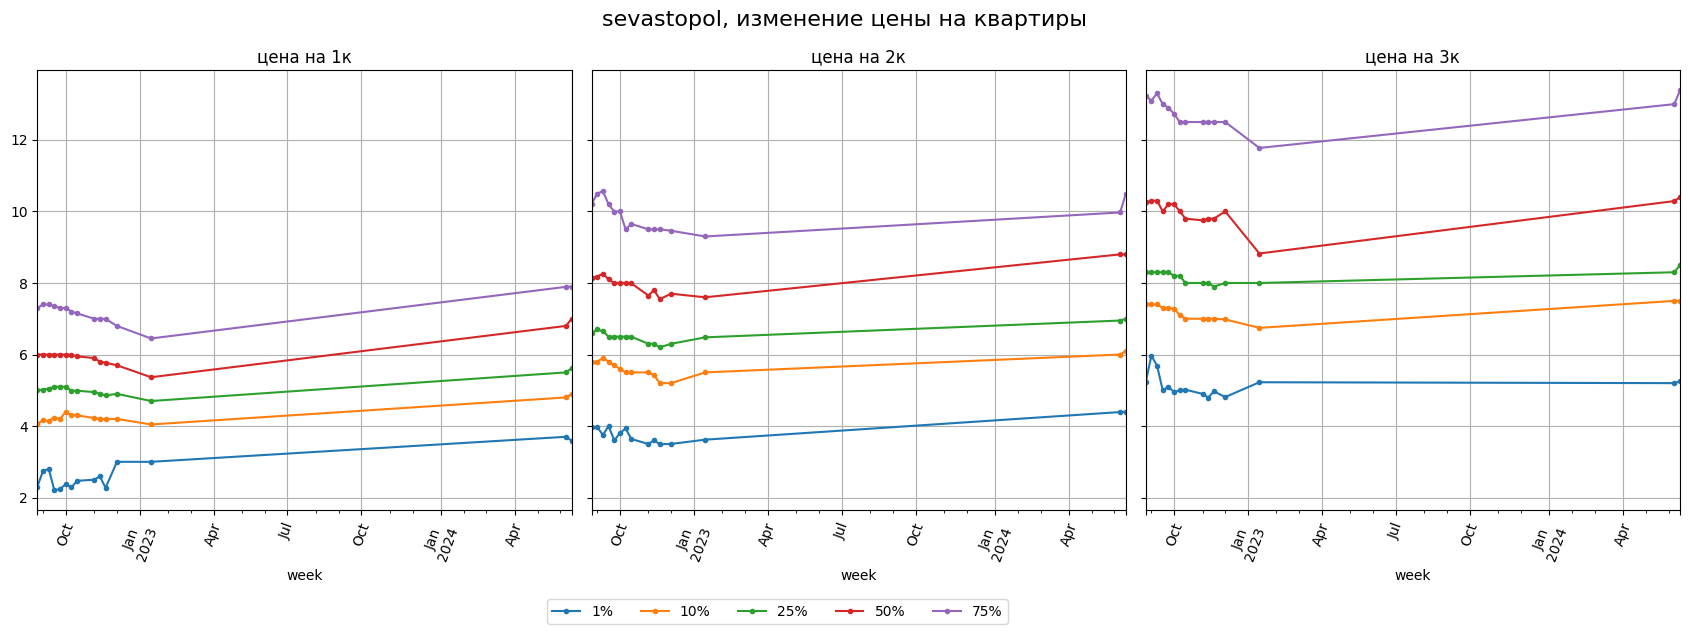

In [33]:
# history_date

place = 'sevastopol'

fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена на {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на квартиры', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

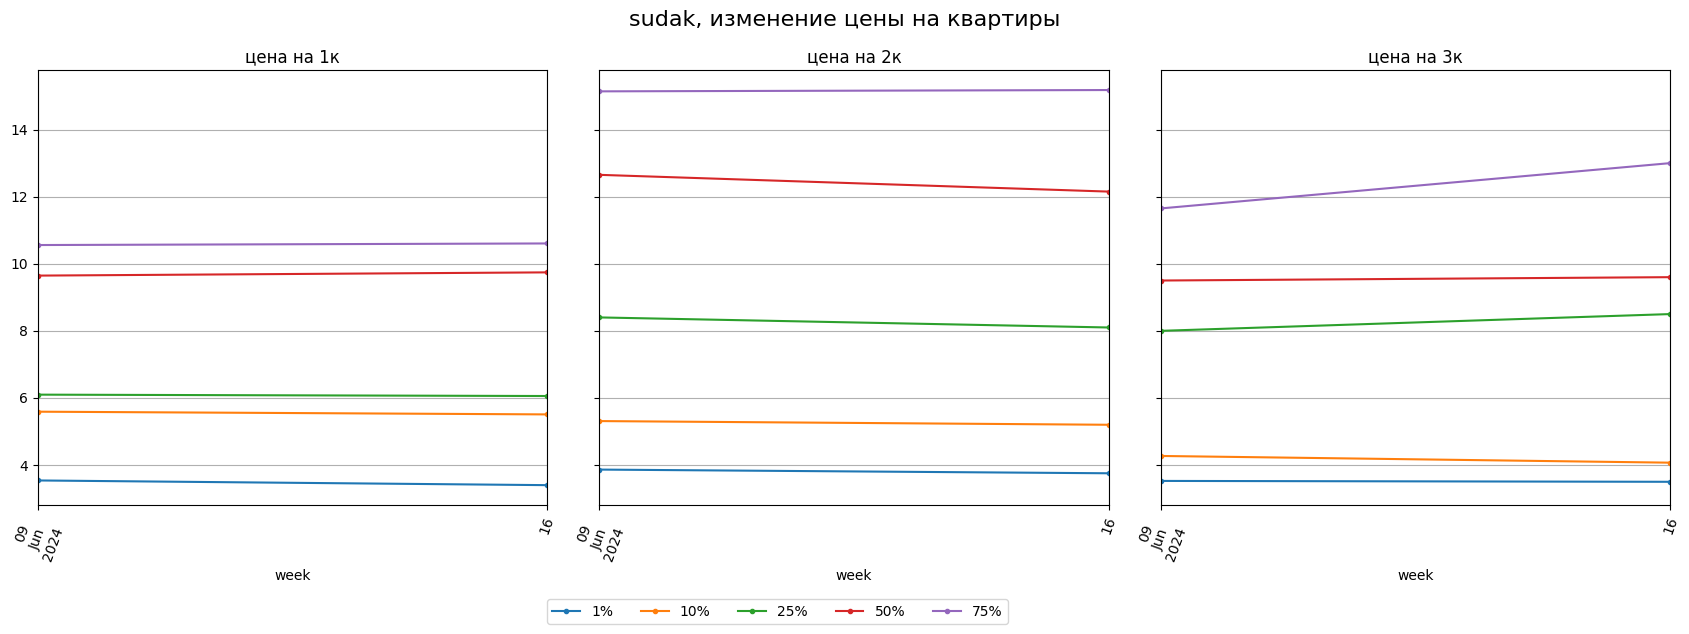

In [34]:
# history_date

place = 'sudak'

fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена на {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на квартиры', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

# актуальная цена

In [35]:
display(len(gdf))
gdf_last = gdf[ gdf['dt'] == gdf['dt'].max() ]
display(len(gdf_last))

77989

1952

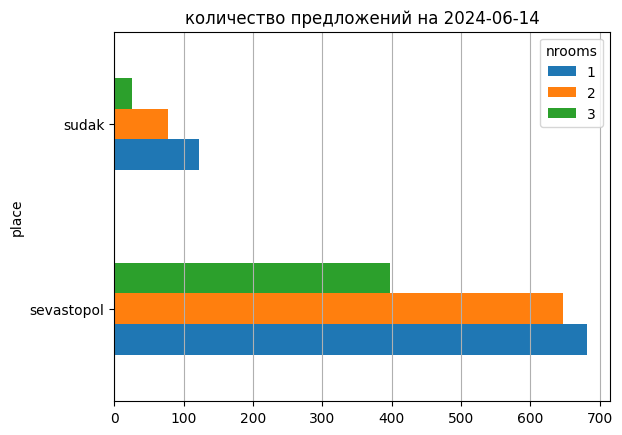

In [36]:
(
gdf_last
.groupby(['nrooms','place'])['url'].count().reset_index()
.pivot(index='place', columns='nrooms', values='url')
.plot.barh(title='количество предложений на '+ str( gdf['dt'].max() ))
.grid(axis='x')    
)

In [37]:
(
    gdf_last
    .groupby(['place','nrooms'])
    ['priceM'].describe(percentiles=percentiles)
)

count  mean  std  min   1%   5%  10%  25%   50%   75%  \
place      nrooms                                                          
sevastopol 1      681.00  7.04 1.91 2.70 3.60 4.50 4.90 5.70  7.00  7.82   
           2      647.00  9.32 3.21 3.50 4.47 5.80 6.10 7.05  8.80 10.50   
           3      398.00 11.92 6.20 4.20 5.20 7.10 7.50 8.43 10.29 13.35   
sudak      1      122.00  8.90 2.47 3.30 4.14 5.14 5.59 6.07  9.77 10.66   
           2       78.00 12.32 5.65 3.70 3.85 4.50 5.05 8.03 12.06 15.20   
           3       26.00 11.34 6.18 3.50 3.52 3.70 4.35 8.70  9.95 12.95   

                    90%   95%   max  
place      nrooms                    
sevastopol 1       9.20 10.00 18.99  
           2      13.50 15.64 33.00  
           3      19.36 22.50 85.00  
sudak      1      11.20 11.44 15.53  
           2      20.95 23.41 25.07  
           3      18.74 23.27 30.00

In [38]:
q_95 = gdf_last.groupby(['place'])['priceM'].quantile(.95)

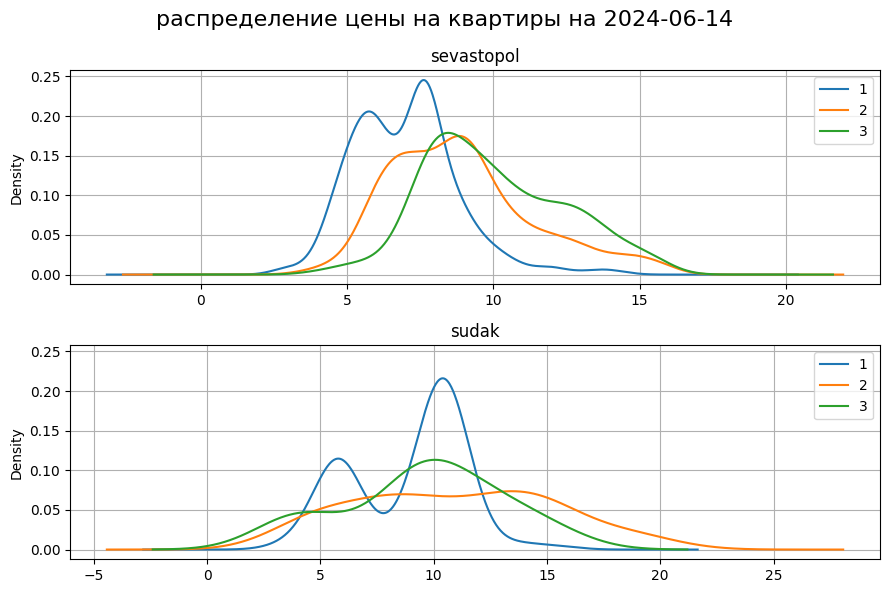

In [39]:
places = ['sevastopol','sudak',]
fig, ax = plt.subplots(len(places),1,figsize=(9,6), sharey=True )
for i,p in enumerate(places): 
    (
        gdf_last
        .query(f'(place=="{p}")&(priceM<{q_95[p]})')
        .groupby(['nrooms'],observed=True)
        ['priceM'].plot.kde(legend=True,ax=ax[i],title=f'{p}', grid=True)   
    )
fig.suptitle(f'распределение цены на квартиры на '+ str( gdf_last['dt'].max() ), fontsize=16)
fig.tight_layout()

# цены на карте

In [40]:
import h3
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint

In [41]:
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

## Севастополь

In [42]:
frame_sevastopol = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf_last.query('place=="sevastopol"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

# frame_sevastopol.explore()

In [43]:
grid = cover_grid_hexagonal( frame_sevastopol.geometry.values[0],cell_size=7 )
grid_values = ( 
    grid
    .sjoin( gdf_last.query('place=="sevastopol"'), how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)
grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## Судак

In [44]:
frame_sudak = gpd.GeoDataFrame([{ # все предложения
            'place':'sudak', 
            'geometry':MultiPoint( gdf_last.query('place=="sudak"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

# frame_sudak.explore()

In [45]:
grid = cover_grid_hexagonal( frame_sudak.geometry.values[0],cell_size=9 )
grid_values = ( 
    grid
    .sjoin( gdf_last.query('place=="sudak"'), how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)
grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

# районы Севастополя

In [46]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
        { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
        for nm,f in frames_index.values
    ],crs='epsg:4326',)

# display(frames)

In [47]:
frames.explore('area_name', legend=True)

In [48]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
'Севастополь, район Острякова',
#'Севастополь, Малахов курган',
]

In [49]:
# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

In [50]:
# фильтруем данные по области
gdf_last_local = gdf_last.sjoin( frame_, how='inner', predicate='within') 
gdf_last_local[['title','priceM','address','geometry']].explore( legend=False)

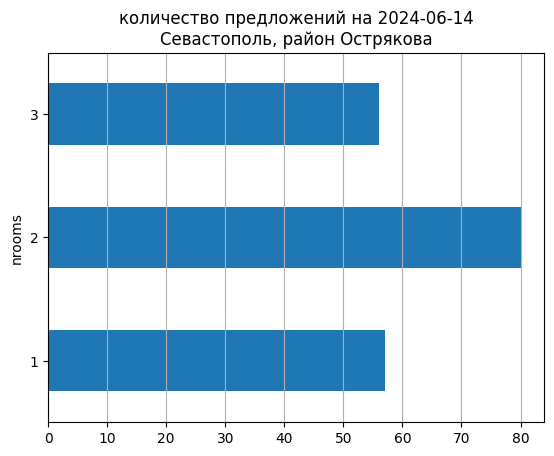

In [51]:
(
    gdf_last_local
    .groupby(['nrooms'])['url'].count()
    .plot.barh(title='количество предложений на '+ str( gdf['dt'].max()) + '\n' + ' / '.join(area_name) )
    .grid(axis='x')   
)

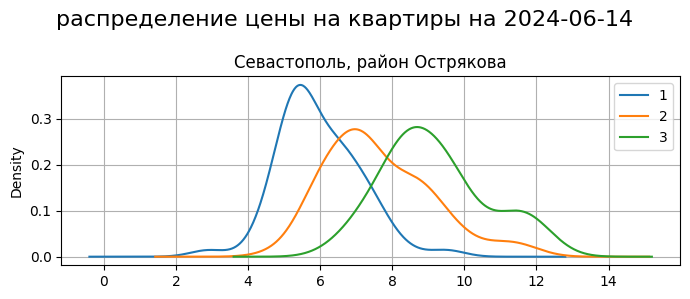

In [52]:
q_95 = gdf_last_local['priceM'].quantile(.95)

fig, ax = plt.subplots(figsize=(7,3) )
(
    gdf_last_local
    .query(f'(priceM<{q_95})')
    .groupby(['nrooms'],observed=True)
    ['priceM'].plot.kde(legend=True,ax=ax,title='/'.join(area_name), grid=True)   
)
fig.suptitle(f'распределение цены на квартиры на '+ str( gdf_last_local['dt'].max() ), fontsize=16)
fig.tight_layout()

----

In [53]:
# изменение цены по району
gdf_local = gdf.sjoin( frame_, how='inner', predicate='within') 

In [54]:
percentiles=[.01,.05,.1,.25,.5,.75,.9]
# stat = gdf_local.groupby(['nrooms','month'],observed=True)['priceM'].describe(percentiles=percentiles)
stat = gdf_local.groupby(['nrooms','week'],observed=True)['priceM'].describe(percentiles=percentiles)
display( stat )

count  mean  std  min   1%   5%  10%  25%  50%  \
nrooms week                                                                    
1      2022-08-22/2022-08-28  90.00  5.74 1.57 1.85 1.98 3.79 4.10 4.80 5.60   
       2022-08-29/2022-09-04 397.00  5.75 1.41 1.85 1.99 3.70 4.10 4.90 5.60   
       2022-09-05/2022-09-11 359.00  5.82 1.36 1.85 2.00 3.60 4.10 5.15 5.80   
       2022-09-12/2022-09-18 380.00  5.71 1.29 1.85 2.00 3.65 4.25 4.95 5.65   
       2022-09-19/2022-09-25 209.00  5.65 1.31 1.85 2.00 3.60 4.20 4.90 5.50   
       2022-09-26/2022-10-02 101.00  5.57 1.37 1.60 1.85 3.60 4.25 4.90 5.40   
       2022-10-03/2022-10-09 111.00  5.42 1.45 1.85 2.00 3.27 4.00 4.60 5.30   
       2022-10-10/2022-10-16 119.00  5.46 1.42 1.85 2.00 3.29 4.00 4.62 5.40   
       2022-10-31/2022-11-06 191.00  5.39 1.45 1.75 1.84 2.67 4.00 4.60 5.40   
       2022-11-07/2022-11-13  99.00  5.48 1.43 1.75 1.85 3.70 4.14 4.60 5.42   
       2022-11-14/2022-11-20 101.00  5.32 1.36 1.85 1.90 3.75 4.00 4.60 5.18   
       2022-11-28/2022-12-04 109.00  5.31 1.23 1.85 2.10 3.97 4.08 4.60 5.00   
       2023-01-09/2023-01-15  64.00  5.36 1.27 1.90 2.28 3.63 4.02 4.69 5.19   
       2024-06-03/2024-06-09 163.00  5.88 1.16 2.90 2.90 4.60 4.85 5.30 5.60   
       2024-06-10/2024-06-16 232.00  5.95 1.08 2.90 2.90 4.59 4.90 5.35 5.75   
2      2022-08-22/2022-08-28 126.00  7.97 2.11 5.40 5.43 5.76 6.25 6.50 7.34   
       2022-08-29/2022-09-04 530.00  7.91 2.08 4.90 5.23 5.70 5.95 6.50 7.25   
       2022-09-05/2022-09-11 481.00  7.99 2.14 3.60 5.20 5.80 6.00 6.50 7.30   
       2022-09-12/2022-09-18 494.00  7.92 2.15 3.60 5.20 5.64 5.85 6.35 7.30   
       2022-09-19/2022-09-25 294.00  7.77 2.17 3.60 5.01 5.48 5.71 6.29 7.00   
       2022-09-26/2022-10-02 138.00  7.79 2.16 3.60 4.24 5.29 5.65 6.29 7.50   
       2022-10-03/2022-10-09 142.00  7.77 2.12 3.80 4.74 5.21 5.50 6.30 7.47   
       2022-10-10/2022-10-16 134.00  7.68 2.07 3.65 4.10 4.96 5.40 6.21 7.25   
       2022-10-31/2022-11-06 233.00  7.48 2.01 3.60 3.95 5.00 5.36 6.00 7.00   
       2022-11-07/2022-11-13 122.00  7.44 1.99 3.60 3.91 5.20 5.40 6.00 7.00   
       2022-11-14/2022-11-20 120.00  7.63 2.11 2.65 4.58 5.20 5.49 6.15 7.33   
       2022-11-28/2022-12-04 131.00  7.27 1.91 2.65 3.93 4.90 5.20 6.03 6.90   
       2023-01-09/2023-01-15  62.00  7.32 2.08 3.65 4.53 5.20 5.50 5.82 6.87   
       2024-06-03/2024-06-09 245.00  8.01 2.62 4.50 4.95 5.80 5.90 6.35 7.30   
       2024-06-10/2024-06-16 329.00  8.23 2.93 4.50 4.85 5.85 5.90 6.70 7.50   
3      2022-08-22/2022-08-28  89.00  9.62 2.37 6.90 6.90 7.00 7.30 7.80 9.00   
       2022-08-29/2022-09-04 336.00  9.54 2.26 6.90 6.90 7.00 7.30 7.80 9.00   
       2022-09-05/2022-09-11 309.00  9.80 2.44 6.15 6.81 7.20 7.30 8.00 9.00   
       2022-09-12/2022-09-18 292.00  9.72 2.41 6.15 6.65 6.96 7.21 8.00 9.00   
       2022-09-19/2022-09-25 157.00  9.69 2.33 6.15 6.46 7.00 7.30 8.00 9.00   
       2022-09-26/2022-10-02  78.00  9.56 2.25 6.50 6.65 7.19 7.30 8.00 9.00   
       2022-10-03/2022-10-09  82.00  9.40 2.16 6.50 6.58 6.91 7.00 7.82 9.00   
       2022-10-10/2022-10-16  91.00  9.50 2.31 6.50 6.50 6.80 7.00 8.00 9.00   
       2022-10-31/2022-11-06 166.00  9.61 2.30 6.20 6.20 7.00 7.15 7.93 9.00   
       2022-11-07/2022-11-13  75.00  9.48 2.32 6.20 6.27 6.90 7.30 7.89 8.70   
       2022-11-14/2022-11-20  75.00  9.27 2.28 6.10 6.17 6.90 7.00 7.79 8.50   
       2022-11-28/2022-12-04  85.00  9.60 2.46 6.00 6.25 6.92 7.29 7.75 8.97   
       2023-01-09/2023-01-15  48.00  9.85 2.60 6.30 6.34 6.50 6.80 7.96 9.70   
       2024-06-03/2024-06-09 157.00  9.60 2.02 6.50 6.50 7.10 7.30 8.30 9.30   
       2024-06-10/2024-06-16 201.00  9.67 2.00 6.50 6.50 7.00 7.50 8.30 9.30   

                               75%   90%   max  
nrooms week                                     
1      2022-08-22/2022-08-28  6.80  7.60 12.00  
       2022-08-29/2022-09-04  6.70  7.55 12.00  
       2022-09-05/2022-09-11  6.75  7.50  9.20  
       2022-09-12/2022-0

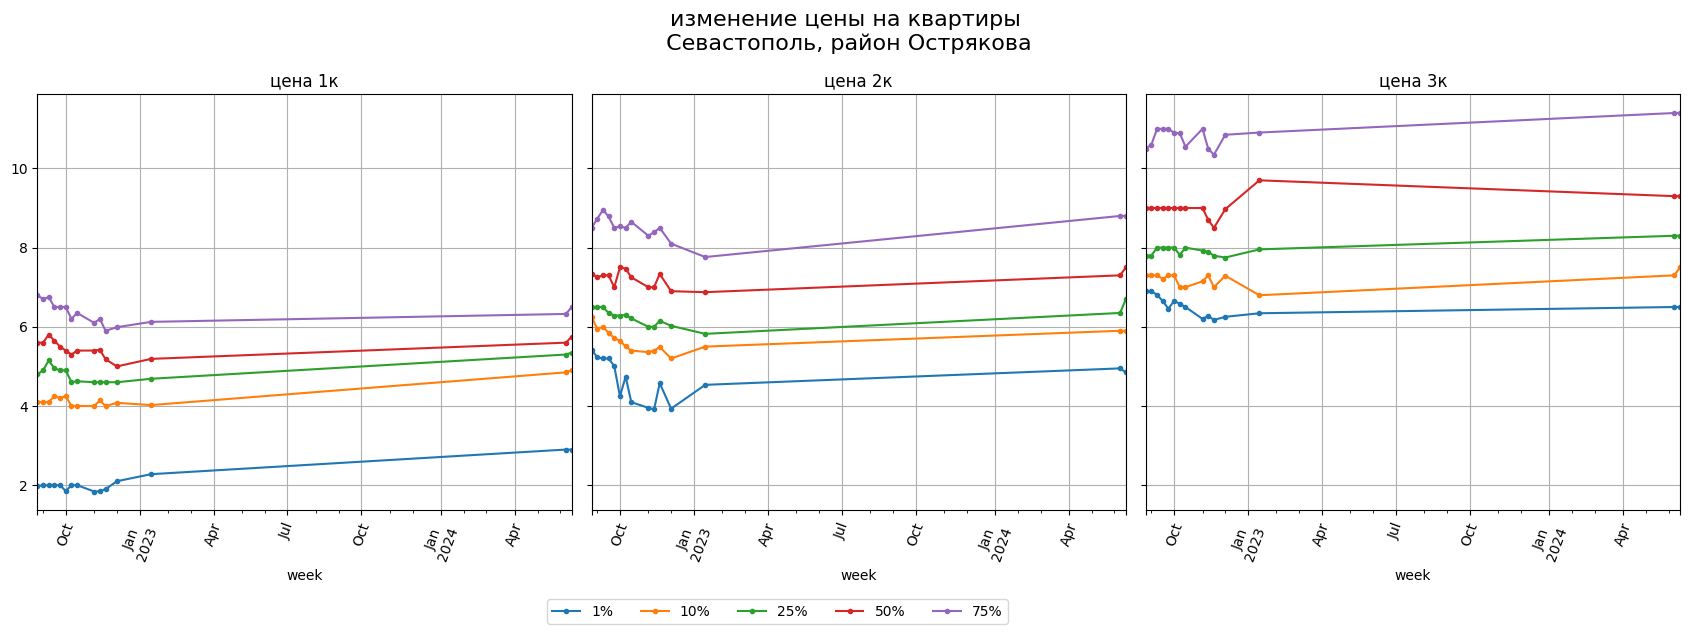

In [55]:
fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(s),cols].plot(title=f'цена {s}к', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'изменение цены на квартиры\n {'/'.join(area_name)}', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

In [ ]:
# gdf_last_local